In [1]:
!mkdir train
!mkdir train/NORMAL
!mkdir train/PNEUMONIA
!mkdir val
!mkdir val/NORMAL
!mkdir val/PNEUMONIA
!mkdir test
!mkdir test/NORMAL
!mkdir test/PNEUMONIA

In [2]:
import os
import shutil
import pickle
with open('/kaggle/input/photos/photos.pickle', 'rb') as f:
    photos=pickle.load(f)
print(photos['train_normal'][0])

4056cac3-6aef-4e85-b40d-166f86811ca4.dcm


In [3]:
source_dir='/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images'
for x in photos['train_normal'] :
  src = os.path.join(source_dir, x)
  dst = os.path.join('/kaggle/working/train/NORMAL/', x)
  shutil.copy(src, dst)
for x in photos['train_pneumonia'] :
  src = os.path.join(source_dir, x)
  dst = os.path.join('/kaggle/working/train/PNEUMONIA/', x)
  shutil.copy(src, dst)
for x in photos['val_normal'] :
  src = os.path.join(source_dir, x)
  dst = os.path.join('/kaggle/working/val/NORMAL/', x)
  shutil.copy(src, dst)
for x in photos['val_pneumonia'] :
  src = os.path.join(source_dir, x)
  dst = os.path.join('/kaggle/working/val/PNEUMONIA/', x)
  shutil.copy(src, dst)
for x in photos['test_normal'] :
  src = os.path.join(source_dir, x)
  dst = os.path.join('/kaggle/working/test/NORMAL/', x)
  shutil.copy(src, dst)
for x in photos['test_pneumonia'] :
  src = os.path.join(source_dir, x)
  dst = os.path.join('/kaggle/working/test/PNEUMONIA/', x)
  shutil.copy(src, dst)


In [4]:

normal_images = os.listdir('train/NORMAL')
pneumonia_images = os.listdir('train/PNEUMONIA')
print('Тренировочная выборка:')
print('Без пневмонии ',  len(normal_images))
print('C пневмонией ',  len(pneumonia_images))
print()

normal_images = os.listdir('val/NORMAL')
pneumonia_images = os.listdir('val/PNEUMONIA')

print('Валидационная выборка:')
print('Без пневмонии ',  len(normal_images))
print('C пневмонией ',  len(pneumonia_images))
print()


normal_images = os.listdir('test/NORMAL')
pneumonia_images = os.listdir('test/PNEUMONIA')

print('Тестовая выборка:')
print('Без пневмонии ',  len(normal_images))
print('C пневмонией ',  len(pneumonia_images))


Тренировочная выборка:
Без пневмонии  16024
C пневмонией  4660

Валидационная выборка:
Без пневмонии  3099
C пневмонией  901

Тестовая выборка:
Без пневмонии  1549
C пневмонией  451


In [5]:
from tqdm import tqdm
import pydicom
from PIL import Image

def convert_dicom_to_jpeg(input_folder, output_folder):
    for filename in tqdm(os.listdir(input_folder)):
        if filename.endswith('.dcm'):
            dicom_file = os.path.join(input_folder, filename)
            dicom_data = pydicom.dcmread(dicom_file)

            image_array = dicom_data.pixel_array
            jpeg_file = os.path.splitext(filename)[0] + '.jpeg'
            jpeg_path = os.path.join(output_folder, jpeg_file)
            image = Image.fromarray(image_array)
            image.save(jpeg_path, "JPEG")
convert_dicom_to_jpeg('/kaggle/working/train/NORMAL', '/kaggle/working/train/NORMAL')
convert_dicom_to_jpeg('/kaggle/working/train/PNEUMONIA', '/kaggle/working/train/PNEUMONIA')
convert_dicom_to_jpeg('/kaggle/working/val/NORMAL', '/kaggle/working/val/NORMAL')
convert_dicom_to_jpeg('/kaggle/working/val/PNEUMONIA', '/kaggle/working/val/PNEUMONIA')
convert_dicom_to_jpeg('/kaggle/working/test/NORMAL', '/kaggle/working/test/NORMAL')
convert_dicom_to_jpeg('/kaggle/working/test/PNEUMONIA', '/kaggle/working/test/PNEUMONIA')

100%|██████████| 451/451 [00:03<00:00, 127.46it/s]


In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-04-11 12:05:25.434672: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-11 12:05:25.434801: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-11 12:05:25.716260: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
from tensorflow.keras.metrics import AUC

In [8]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D


base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(512, 512, 3))
'''
for layer in base_model.layers[:600]:
    layer.trainable = False
for layer in base_model.layers[600:]:
    layer.trainable = True
'''
for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)

loss=tf.keras.losses.BinaryCrossentropy()
#loss=tf.keras.losses.MeanSquaredError()

model.compile(loss=loss,
              optimizer=optimizer,
              metrics= [AUC()])

train_data_dir = '/kaggle/working/train'
val_data_dir = '/kaggle/working/val'
test_data_dir = '/kaggle/working/test'


train_datagen = ImageDataGenerator()#rescale=1./255)
val_datagen = ImageDataGenerator()#rescale=1./255)
test_datagen = ImageDataGenerator()#rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        #target_size=(1024, 1024),
        target_size=(512, 512),
        batch_size=20,
        class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
        val_data_dir,
        target_size=(512, 512),
        batch_size=20,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(512, 512),
        batch_size=20,
        class_mode='binary')

checkpoint_filepath = 'saved_model/big_dataset_model.keras'
#checkpoint_dir = os.path.dirname(checkpoint_filepath)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_auc',
    mode='max',
    save_best_only=True)



history=model.fit(train_generator, epochs=10, validation_data=validation_generator, callbacks=[model_checkpoint_callback], verbose=2)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 20684 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-04-11 12:10:51.918249: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,32,253,253]{3,2,1,0}, f32[20,64,253,253]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-11 12:10:52.784106: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.865957749s
Trying algorithm eng0{} for conv (f32[64,3

1035/1035 - 1090s - 1s/step - auc: 0.7840 - loss: 0.4432 - val_auc: 0.8438 - val_loss: 0.4407
Epoch 2/10
1035/1035 - 869s - 839ms/step - auc: 0.8324 - loss: 0.3996 - val_auc: 0.8445 - val_loss: 0.5476
Epoch 3/10
1035/1035 - 869s - 840ms/step - auc: 0.8455 - loss: 0.3864 - val_auc: 0.8649 - val_loss: 0.4958
Epoch 4/10
1035/1035 - 866s - 837ms/step - auc: 0.8558 - loss: 0.3755 - val_auc: 0.7523 - val_loss: 0.4641
Epoch 5/10
1035/1035 - 867s - 838ms/step - auc: 0.8571 - loss: 0.3741 - val_auc: 0.8632 - val_loss: 0.4302
Epoch 6/10
1035/1035 - 867s - 837ms/step - auc: 0.8639 - loss: 0.3666 - val_auc: 0.8566 - val_loss: 0.3889
Epoch 7/10
1035/1035 - 867s - 837ms/step - auc: 0.8691 - loss: 0.3609 - val_auc: 0.8437 - val_loss: 0.5856
Epoch 8/10
1035/1035 - 866s - 837ms/step - auc: 0.8742 - loss: 0.3550 - val_auc: 0.8469 - val_loss: 1.0411
Epoch 9/10
1035/1035 - 866s - 837ms/step - auc: 0.8834 - loss: 0.3434 - val_auc: 0.8585 - val_loss: 0.3782
Epoch 10/10
1035/1035 - 922s - 891ms/step - auc: 0

In [64]:
#!mkdir ckpt
#model=tf.keras.models.load_model(checkpoint_filepath)

In [70]:
model.save('big_dataset_model.keras')

In [9]:


val_generator = val_datagen.flow_from_directory(
        '/kaggle/working/val',
        target_size=(512, 512),
        batch_size=20,
        class_mode='binary',
        shuffle=False)
pred=model.predict(val_generator)

Found 4000 images belonging to 2 classes.
  1/200 ━━━━━━━━━━━━━━━━━━━━ 20:44 6s/step

W0000 00:00:1712846447.458172      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


200/200 ━━━━━━━━━━━━━━━━━━━━ 51s 223ms/step


In [10]:
val_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [11]:
from sklearn.metrics import roc_auc_score
roc_auc_score(val_generator.classes, pred)
#0.8482541486603903

0.8622830965844483

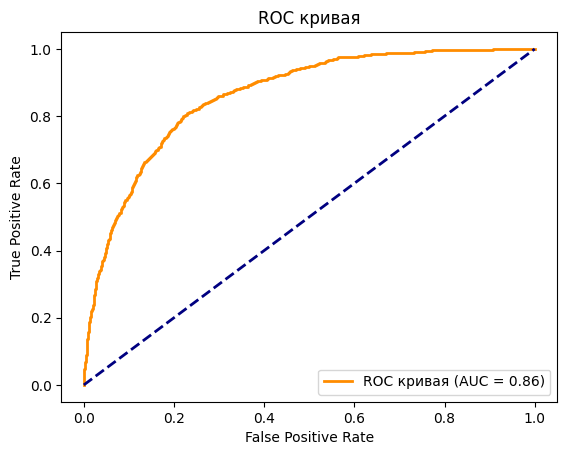

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(val_generator.classes, pred, drop_intermediate=True)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC кривая (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая')
plt.legend(loc="lower right")
plt.show()


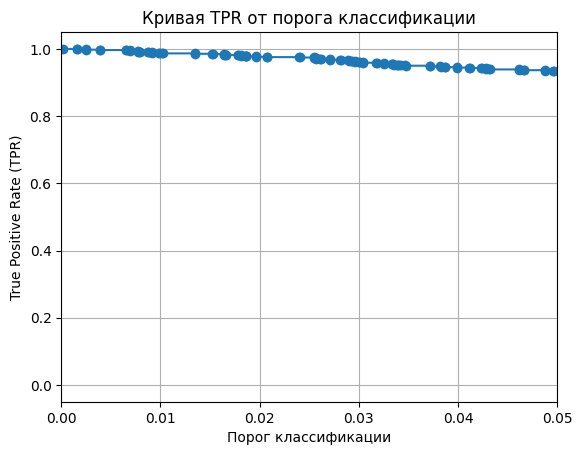

In [13]:
plt.plot(thresholds, tpr, marker='o', linestyle='-')
plt.xlabel('Порог классификации')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Кривая TPR от порога классификации')
plt.grid(True)
plt.xlim(0,0.05)
plt.show()


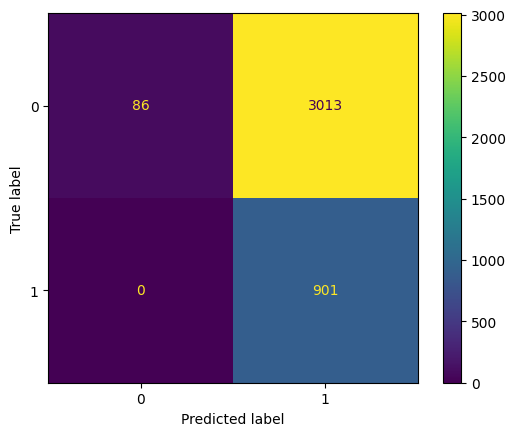

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
predicted_classes=(pred>0.001).astype(int)
cm=confusion_matrix(val_generator.classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


In [15]:
sum(pred<0.001)/len(pred)

array([0.0215])

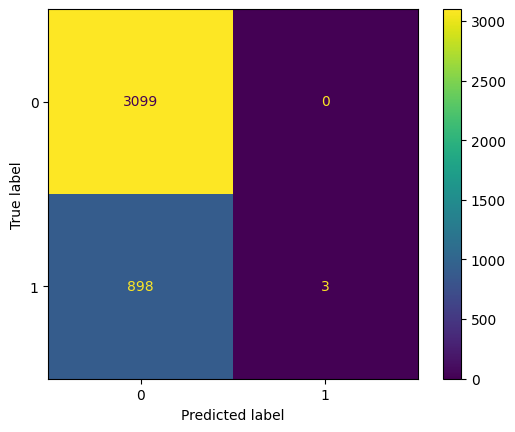

In [24]:
predicted_classes=(pred>0.99).astype(int)
cm=confusion_matrix(val_generator.classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [18]:
sum(pred>0.99)/len(pred)

array([0.00075])

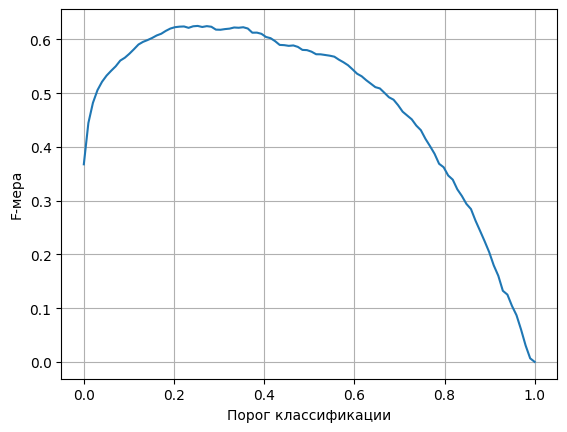

In [26]:
from sklearn.metrics import f1_score
import numpy as np
thresholds = np.linspace(0, 1, 100)  
y_true=np.array(val_generator.classes)
y_pred=np.array(pred)
f_scores = [f1_score(y_true, (y_pred > threshold).astype(int)) for threshold in thresholds]

plt.plot(thresholds, f_scores)
plt.xlabel('Порог классификации')
plt.ylabel('F-мера')
plt.grid(True)
plt.show()

In [27]:
np.argmax(f_scores)

25

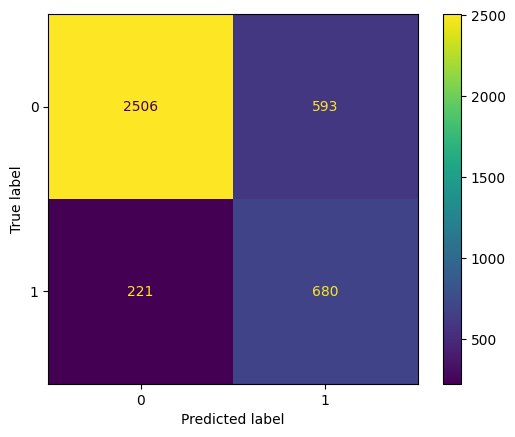

In [28]:
predicted_classes=(pred>0.25).astype(int)
cm=confusion_matrix(val_generator.classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

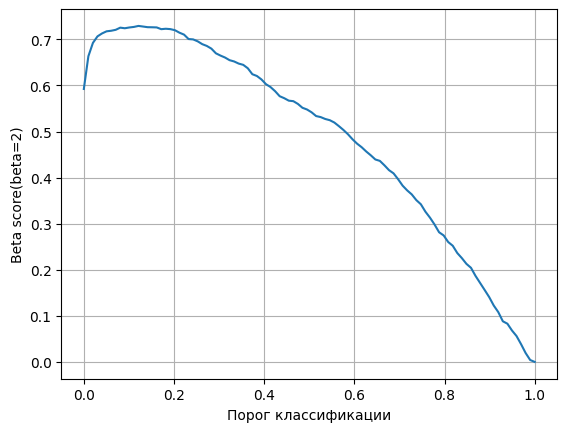

In [29]:
from sklearn.metrics import fbeta_score
thresholds = np.linspace(0, 1, 100)  
y_true=np.array(val_generator.classes)
y_pred=np.array(pred)
f_scores = [fbeta_score(y_true, (y_pred > threshold).astype(int), beta=2) for threshold in thresholds]

plt.plot(thresholds, f_scores)
plt.xlabel('Порог классификации')
plt.ylabel('Beta score(beta=2)')
plt.grid(True)
plt.show()

In [30]:
np.argmax(f_scores)

12

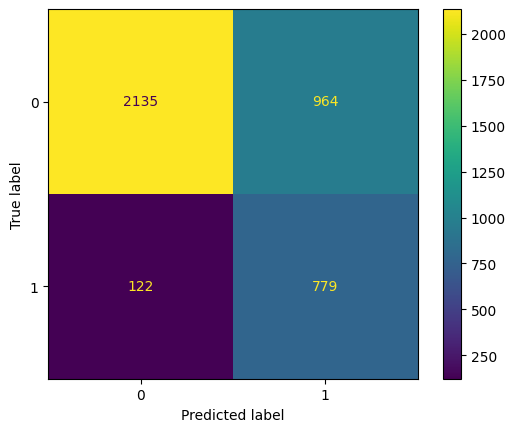

In [31]:
predicted_classes=(pred>0.12).astype(int)
cm=confusion_matrix(val_generator.classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

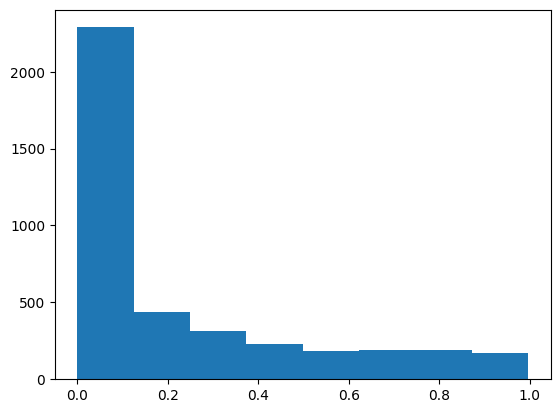

In [34]:
plt.hist(pred, bins=8)
plt.show()

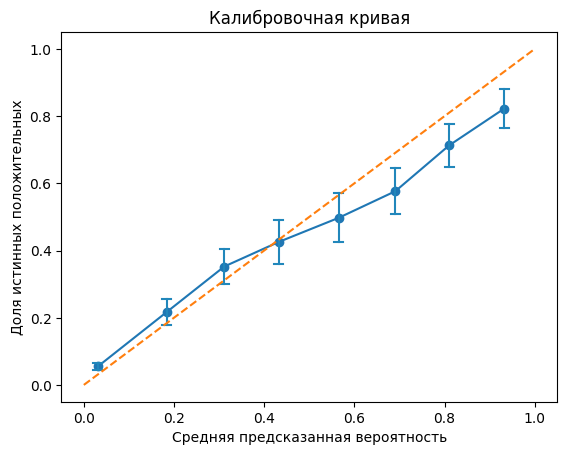

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

preds = np.squeeze(pred)
num_bins=8
prob_true, prob_pred = calibration_curve(val_generator.classes, preds, n_bins=num_bins)
interval=1/num_bins
threshold=0
objects_in_bin=[]
for i in range(num_bins) :
    threshold+=interval
    number_of_objects=0
    for j in range(len(pred)) :
        if threshold>pred[j]>threshold-interval :
            number_of_objects+=1
    objects_in_bin.append(number_of_objects)
confidence_intervals=[]
for i in range(num_bins) :
    upper=prob_true[i]+1.96*(prob_true[i]*(1-prob_true[i]))**(1/2)/objects_in_bin[i]**(1/2)
    lower=prob_true[i]-1.96*(prob_true[i]*(1-prob_true[i]))**(1/2)/objects_in_bin[i]**(1/2)
    #print(lower)
    confidence_intervals.append([lower, upper])
#print(confidence_intervals)
horizontal_line_width=0.02
    #plt.errorbar(x, (low+high)/2, yerr=(high-low)/2, fmt='none', color='blue')
plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
for x, [low, high] in zip(prob_pred, confidence_intervals):
    #print(x, low, high)
    left= x - horizontal_line_width / 2
    right=x + horizontal_line_width / 2
    plt.plot([x, x], [low, high], color='#2187bb')
    plt.plot([left, right], [high, high], color='#2187bb')
    plt.plot([left, right], [low, low], color='#2187bb')
plt.xlabel('Средняя предсказанная вероятность')
plt.ylabel('Доля истинных положительных')
plt.title('Калибровочная кривая')
plt.plot([0,1], [0,1], linestyle='--', label='Идеальный классификатор')
plt.show()

In [55]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=99999999999, solver='lbfgs')
lr.fit(pred.reshape(-1,1), val_generator.classes)

LogisticRegression(C=99999999999)

In [56]:
import pickle


with open('logistic_regression.pkl','wb') as f:
    pickle.dump(lr,f)

'''
with open('logistic_regression.pkl', 'rb') as f:
    lr = pickle.load(f)
'''

"\nwith open('logistic_regression.pkl', 'rb') as f:\n    lr = pickle.load(f)\n"

In [57]:
print(lr.predict_proba(pred)[:, 1])

[0.06835936 0.09887922 0.40321175 ... 0.24214872 0.40014673 0.34160473]


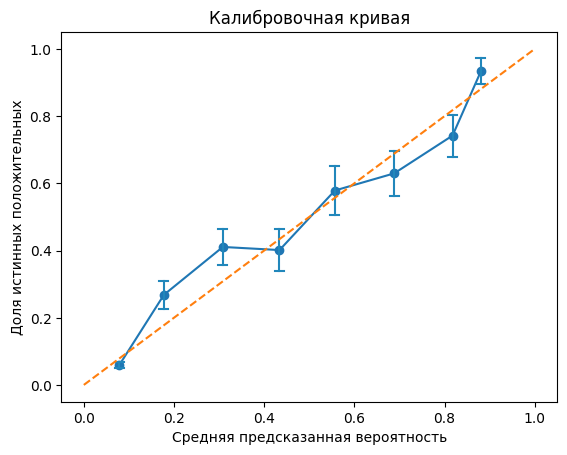

In [59]:
preds = np.squeeze(pred)
num_bins=8
prob_true, prob_pred = calibration_curve(val_generator.classes, lr.predict_proba(pred)[:, 1], n_bins=num_bins)
interval=1/num_bins
threshold=0
objects_in_bin=[]
for i in range(num_bins) :
    threshold+=interval
    number_of_objects=0
    for j in range(len(pred)) :
        if threshold>pred[j]>threshold-interval :
            number_of_objects+=1
    objects_in_bin.append(number_of_objects)
confidence_intervals=[]
for i in range(num_bins) :
    upper=prob_true[i]+1.96*(prob_true[i]*(1-prob_true[i]))**(1/2)/objects_in_bin[i]**(1/2)
    lower=prob_true[i]-1.96*(prob_true[i]*(1-prob_true[i]))**(1/2)/objects_in_bin[i]**(1/2)
    #print(lower)
    confidence_intervals.append([lower, upper])
#print(confidence_intervals)
horizontal_line_width=0.02
    #plt.errorbar(x, (low+high)/2, yerr=(high-low)/2, fmt='none', color='blue')
plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
for x, [low, high] in zip(prob_pred, confidence_intervals):
    #print(x, low, high)
    left= x - horizontal_line_width / 2
    right=x + horizontal_line_width / 2
    plt.plot([x, x], [low, high], color='#2187bb')
    plt.plot([left, right], [high, high], color='#2187bb')
    plt.plot([left, right], [low, low], color='#2187bb')
plt.xlabel('Средняя предсказанная вероятность')
plt.ylabel('Доля истинных положительных')
plt.title('Калибровочная кривая')
plt.plot([0,1], [0,1], linestyle='--', label='Идеальный классификатор')
plt.show()

In [60]:

test_generator = test_datagen.flow_from_directory(
        '/kaggle/working/test',
        target_size=(512, 512),
        batch_size=20,
        class_mode='binary',
        shuffle=False)
pred=model.predict(test_generator)


Found 2000 images belonging to 2 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 231ms/step


In [61]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
print(fbeta_score(test_generator.classes, (pred > 0.12).astype(int), beta=2))
print(precision_score(test_generator.classes, (pred > 0.12).astype(int)))
print(recall_score(test_generator.classes, (pred > 0.12).astype(int)))
print(accuracy_score(test_generator.classes, (pred > 0.12).astype(int)))

0.7081464872944693
0.43463302752293576
0.8403547671840355
0.7175


In [62]:

print(f1_score(test_generator.classes, (pred > 0.25).astype(int)))
print(precision_score(test_generator.classes, (pred > 0.25).astype(int)))
print(recall_score(test_generator.classes, (pred > 0.25).astype(int)))
print(accuracy_score(test_generator.classes, (pred > 0.25).astype(int)))

0.6086956521739132
0.5222222222222223
0.729490022172949
0.7885


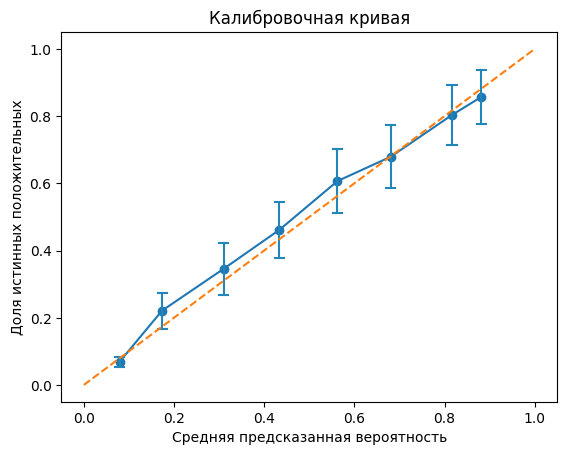

In [64]:

preds = np.squeeze(pred)
num_bins=8
prob_true, prob_pred = calibration_curve(test_generator.classes, lr.predict_proba(pred)[:, 1], n_bins=num_bins)
interval=1/num_bins
threshold=0
objects_in_bin=[]
for i in range(num_bins) :
    threshold+=interval
    number_of_objects=0
    for j in range(len(pred)) :
        if threshold>pred[j]>threshold-interval :
            number_of_objects+=1
    objects_in_bin.append(number_of_objects)
confidence_intervals=[]
for i in range(num_bins) :
    upper=prob_true[i]+1.96*(prob_true[i]*(1-prob_true[i]))**(1/2)/objects_in_bin[i]**(1/2)
    lower=prob_true[i]-1.96*(prob_true[i]*(1-prob_true[i]))**(1/2)/objects_in_bin[i]**(1/2)
    #print(lower)
    confidence_intervals.append([lower, upper])
#print(confidence_intervals)
horizontal_line_width=0.02
    #plt.errorbar(x, (low+high)/2, yerr=(high-low)/2, fmt='none', color='blue')
plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
for x, [low, high] in zip(prob_pred, confidence_intervals):
    #print(x, low, high)
    left= x - horizontal_line_width / 2
    right=x + horizontal_line_width / 2
    plt.plot([x, x], [low, high], color='#2187bb')
    plt.plot([left, right], [high, high], color='#2187bb')
    plt.plot([left, right], [low, low], color='#2187bb')
plt.xlabel('Средняя предсказанная вероятность')
plt.ylabel('Доля истинных положительных')
plt.title('Калибровочная кривая')
plt.plot([0,1], [0,1], linestyle='--', label='Идеальный классификатор')
plt.show()

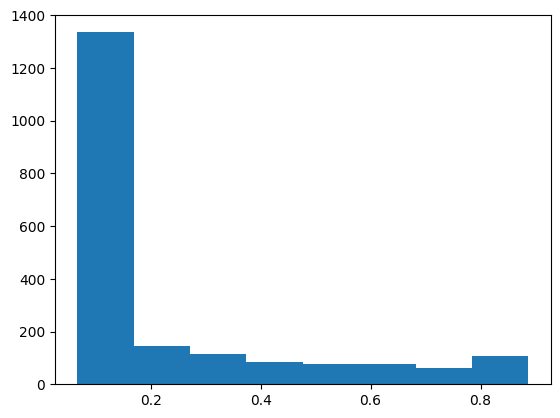

In [65]:
plt.hist(lr.predict_proba(pred)[:, 1], bins=8)
plt.show()

In [67]:
test_generator = test_datagen.flow_from_directory(
        '/kaggle/working/test',
        target_size=(512, 512),
        batch_size=20,
        class_mode='binary',
        shuffle=False)


Found 2000 images belonging to 2 classes.


In [68]:
'''
model=tf.keras.models.load_model('big_dataset_model.keras')
with open('logistic_regression.pkl', 'rb') as f:
    lr = pickle.load(f)
'''
def predict(photos, threshold) :
    predictions=model.predict(photos)
    calibrated_probabilities=lr.predict_proba(predictions)[:, 1]
    return (predictions > threshold).astype(int).reshape(1,-1)[0], calibrated_probabilities

In [69]:
preds, probas=predict(test_generator, 0.12)
print(len(preds))
print(len(probas))

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 227ms/step
2000
2000
